## Celligner 2: trials

### setting up

In [1]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner2.dataset import anndata
import pandas as pd
# to comment in your case
from depmapomics import tracker as track

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

import celligner2

Loading BokehJS ...

In [2]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [3]:
dataset = read_h5ad("temp/celligner_multi.h5ad")

### some late cleanups

In [5]:
# removing ultra rare samples

In [4]:
MINEXAMPLE=4

In [5]:
todrop = []
for k, v in Counter(dataset.obs["disease_type"]).items():
    if v <MINEXAMPLE:
        print(k)
        todrop.append(k)
loc = dataset.obs["disease_type"].isin(todrop)
dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

endometrial_squamous
glassy_cell_carcinoma
breast_adenocarcinoma
ovary_carcinoma
thyroid_squamous
unspecified_leukemia
b-cell,_non-hodgkins,_burkitts
cervical_adenocarcinoma
uterine_sarcoma
teratoma
mullerian_carcinoma
sccoht
merkel_cell_carcinoma
thyroid_sarcoma
duodenal_adenocarcinoma
b-cell
clear_cell_carcinoma
krukenberg_tumor
chondrosarcoma
choriocarcinoma
mixed_germ_cell
endometrial_adenosquamous
endometrial_stromal_sarcoma
thymic_carcinoma
brenner_tumor
atl
prostate_small_cell
endocrine
prostate_hyperplasia
lung_carcinoid
angiosarcoma
acinar_cell_carcinoma
melanotic_neuroectodermal_tumor
gliomatosis_cerebri
nut_midline_carcinoma
myoepithelial_carcinoma
myeloid_neoplasm_nos
neurofibroma
nasopharyngeal_carcinoma
perivascular_epithelioid_cell_neoplasms
clear_cell_carcinoma_of_cervix
epithelioid_hemangioendothelioma
juvenile_myelomonocytic_leukemia
alveolar_sarcoma
pleuropulmonary_blastoma
craniopharyngioma
adrenocortical_adenoma
rosette_forming_glioneuronal_tumor
neuroendocrine_car

In [6]:
todrop = []
for k, v in Counter(dataset.obs["lineage"]).items():
    if v <MINEXAMPLE:
        print(k)
        todrop.append(k)
loc = dataset.obs["lineage"].isin(todrop)
dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

fibroblast_upper_aerodigestive
fibroblast_lymphocyte
fibroblast_colorectal
fibroblast_soft_tissue
fibroblast_urinary_tract


In [7]:
for val in ['dataset','ends', 'reference', 'method', 'sequencer']:
    print(val, set(dataset.obs[val]))

dataset {'hcmi', 'met500', 'pediatric_PDX', 'tcga', 'ccle', 'cclf'}
ends {'paired end'}
reference {'hg38', 'hg19'}
method {'bulk'}
sequencer {'Illumina HiSeq 2000', 'Illumina HiSeq 4000', 'Illlumina TruSeq'}


In [8]:
#TODO: try batch norm use_bn=True, use_ln=False, https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
#TODO

In [9]:
dataset.obs.replace({'u':'U', 'other': 'U', '': 'none'}, inplace=True)

In [10]:
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='ccle'), 'align'] = 'STAR'
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='met500'), 'align'] = 'STAR'

In [11]:
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='ccle'), 'counter'] = 'RSEM'
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='met500'), 'counter'] = 'RSEM'

we can use estimation for the missing values in the conditional dataset

In [12]:
dataset.obs.loc[(dataset.obs['cell_format']=='U') & dataset.obs['dataset'].isin(['hcmi','cclf']), "cell_format"] = ["2D","3D","3D","3D","3D"]# = evaluator.adata_latent.obs.loc[dataset.obs.loc[(dataset.obs['cell_format']=='U')].index, 'cell_format_pred']

In [13]:
print(set(dataset.obs.loc[(dataset.obs['cell_format']=='U')].dataset))
dataset.obs['cell_format'] = dataset.obs['cell_format'].cat.rename_categories({'U':'none'})

{'tcga', 'met500'}


In [14]:
print(set(dataset.obs.loc[(dataset.obs['conservation']=='U')].dataset))
dataset.obs['conservation'] = dataset.obs['conservation'].cat.rename_categories({'U':'none'})

{'tcga', 'met500'}


In [15]:
dataset.obs.loc[dataset.obs.sample_type=='model', 'contamination'] = 'none'

In [16]:
dataset.obs.morphology = dataset.obs.morphology.cat.add_categories('none')
dataset.obs.loc[dataset.obs.sample_type!='model', 'morphology'] = 'none'

In [17]:
low_nan_genes = np.isnan(dataset.X).sum(0)<len(dataset.X)*0.01
loc = np.argsort(np.nanvar(dataset.X[:,low_nan_genes], 0))[-3000:]
dataset = AnnData(dataset.X[:,low_nan_genes][:,loc], dataset.obs, dataset.var[low_nan_genes].iloc[loc])

In [20]:
(np.isnan(dataset.X).sum(0)).sum()

435

In [30]:
dataset.X.var(0)

array([ 2.2 ,  2.2 ,  2.2 ,  2.2 ,  2.2 ,  2.21,  2.21, ..., 14.42, 14.55,
       14.82, 15.28, 16.08, 16.18, 18.78], dtype=float32)

In [18]:
cols = ['dataset','reference','sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format']

In [19]:
pred = ['lineage', 'age', "sex",'disease_type', 'doublingt' , 'cell_type', 'morphology', 'instability', 'hasebv', 'stage']#,'contamination']

## learning on hcmi and met500 with leiden clust 

In [35]:
tosend = dataset.copy()
tosend.obs.loc[tosend.obs.dataset.isin(['hcmi', 'met500']), pred] = 'U'
cl2 = celligner2.CELLIGNER2(
    adata=tosend,
    condition_keys=cols,
    predictor_keys=pred,
    hidden_layer_sizes=[512, 128],
    classifier_hidden_layer_sizes=[32, 64],
    use_mmd = True,
    latent_dim=16,
    beta=200,
    betaclass=0.8,
    apply_log=True,
    mmd_on='y1'
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    #cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)

         Falling back to preprocessing with `sc.pp.pca` and default params.



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 512 27
	Hidden Layer 1 in/out: 512 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 160 

Decoder Architecture:
	First Layer in, out and cond:  16 128 27
	Hidden Layer 1 in/out: 128 512
	Output Layer in/out:  512 3000 

using leiden clustering to define training group mixing


         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |██------------------| 13.0%  - val_loss: 6904.6640119881 - val_recon_loss: 4639.7256027748 - val_kl_loss: 180.4795826879 - val_class_ce_loss: 261.4751934183 - val_mmd_loss: 2003.42893297922
ADJUSTED LR
 |███-----------------| 17.7%  - val_loss: 7039.6325431034 - val_recon_loss: 4599.5255758351 - val_kl_loss: 185.2660411966 - val_class_ce_loss: 228.7762514312 - val_mmd_loss: 2211.2824928021
ADJUSTED LR
 |████----------------| 20.0%  - val_loss: 7428.6157394935 - val_recon_loss: 4596.2048255657 - val_kl_loss: 183.5236684865 - val_class_ce_loss: 227.9682054191 - val_mmd_loss: 2604.3885887409
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 38


In [36]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

In [24]:
evaluator.adata_latent.obs[pred] = dataset.obs[pred]

In [30]:
evaluator.get_class_quality(classes=pred, only=['hcmi', 'met500'], on="dataset")

lineage
all predicted categories:  {'esophagus', 'stomach', 'adrenal', 'bladder', 'liver', 'blood', 'skin', 'lung', 'pancreas', 'prostate', 'ovary', 'thyroid', 'colon', 'soft_tissue', 'germ_cell', 'kidney', 'central_nervous_system', 'bile_duct', 'peripheral_nervous_system', 'cervix', 'breast', 'gastric', 'upper_aerodigestive', 'bone', 'uterus'}
accuracy:  0.3194774346793349
F1 Score (weigthed): 0.27
F1 Score (macro): 0.22


age
all predicted categories:  {'Adult', 'Pediatric', 'Children'}
accuracy:  0.7304964539007093
F1 Score (weigthed): 0.63
F1 Score (macro): 0.39


sex
all predicted categories:  {'male', 'female'}
accuracy:  0.8014184397163121
F1 Score (weigthed): 0.79
F1 Score (macro): 0.80


disease_type
all predicted categories:  {'neural_crest-like', 'pancreatic_adenocarcinoma', 'uterine_endometrioid', 'prostate_adenocarcinoma', 'esophogeal_carcinoma', 'desmoplastic_small_round_cell_tumor', 'lung_squamous_cell_carcinoma', 'kidney_clear_cell_carcinoma', 'esophageal_carcinoma', 't

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: division by zero

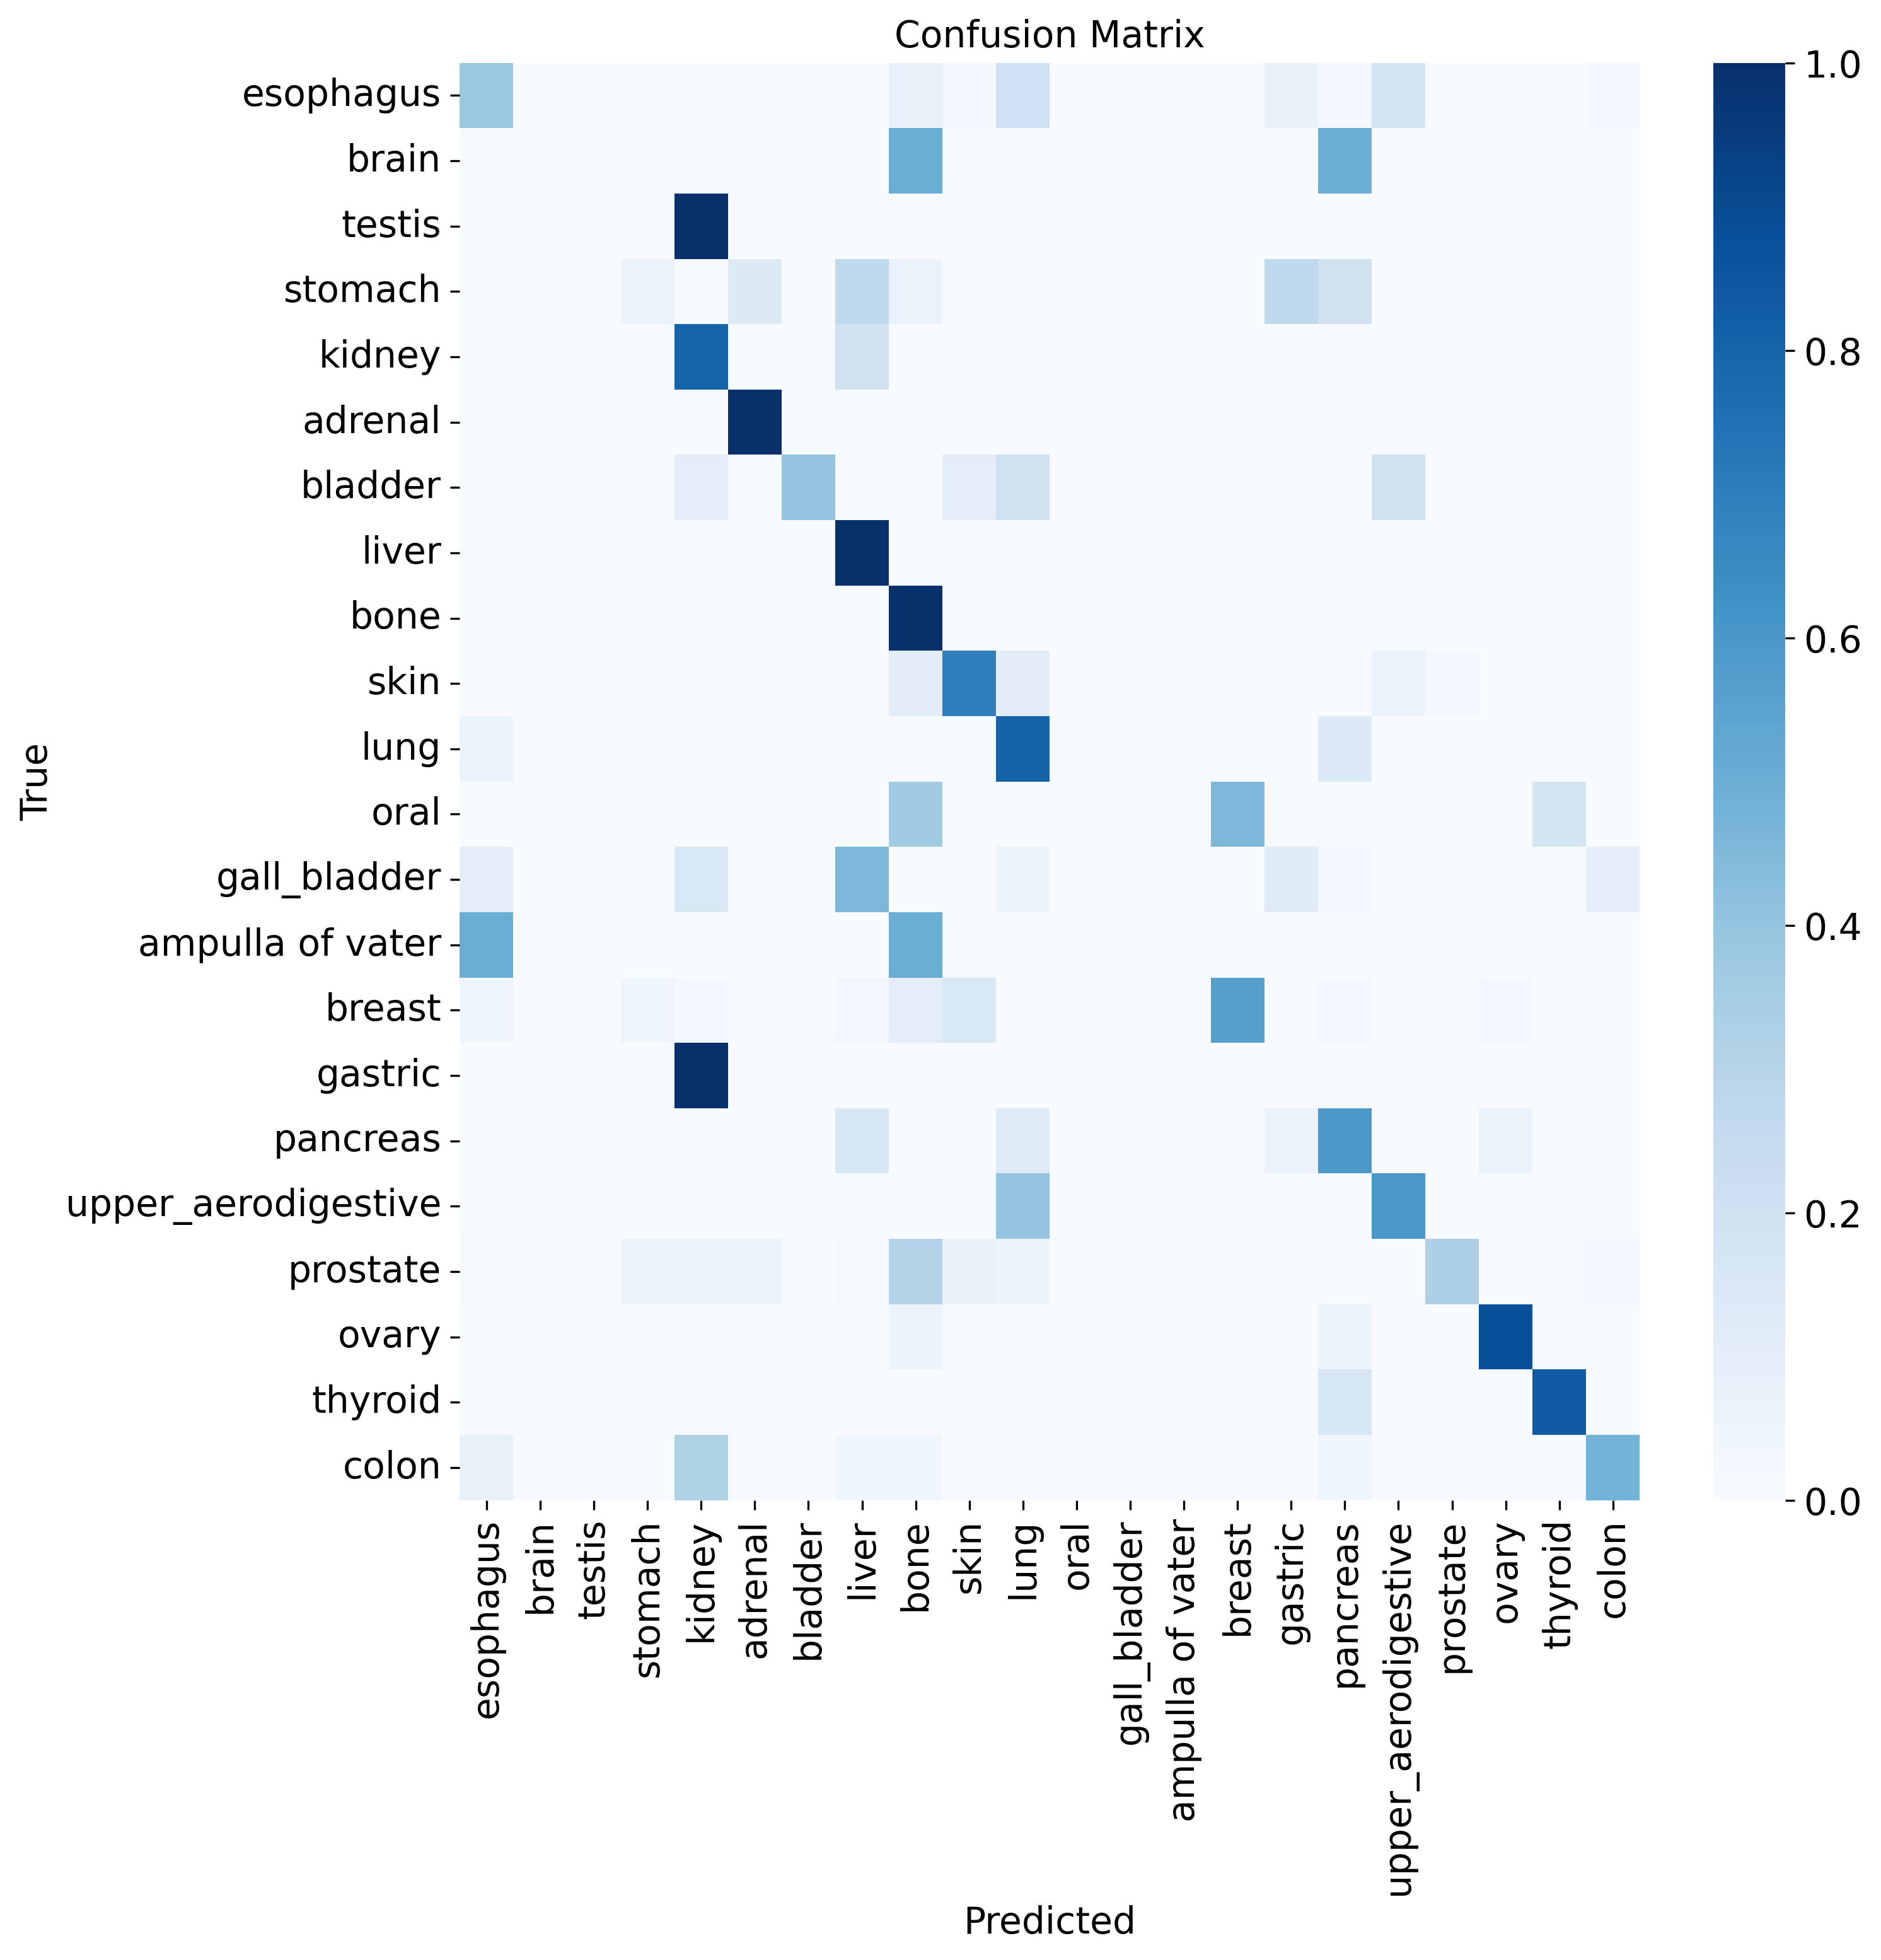

In [26]:
conf = evaluator.get_confusion_matrix(of="lineage", only=['hcmi', 'met500'], on='dataset', figsize=(10,10))

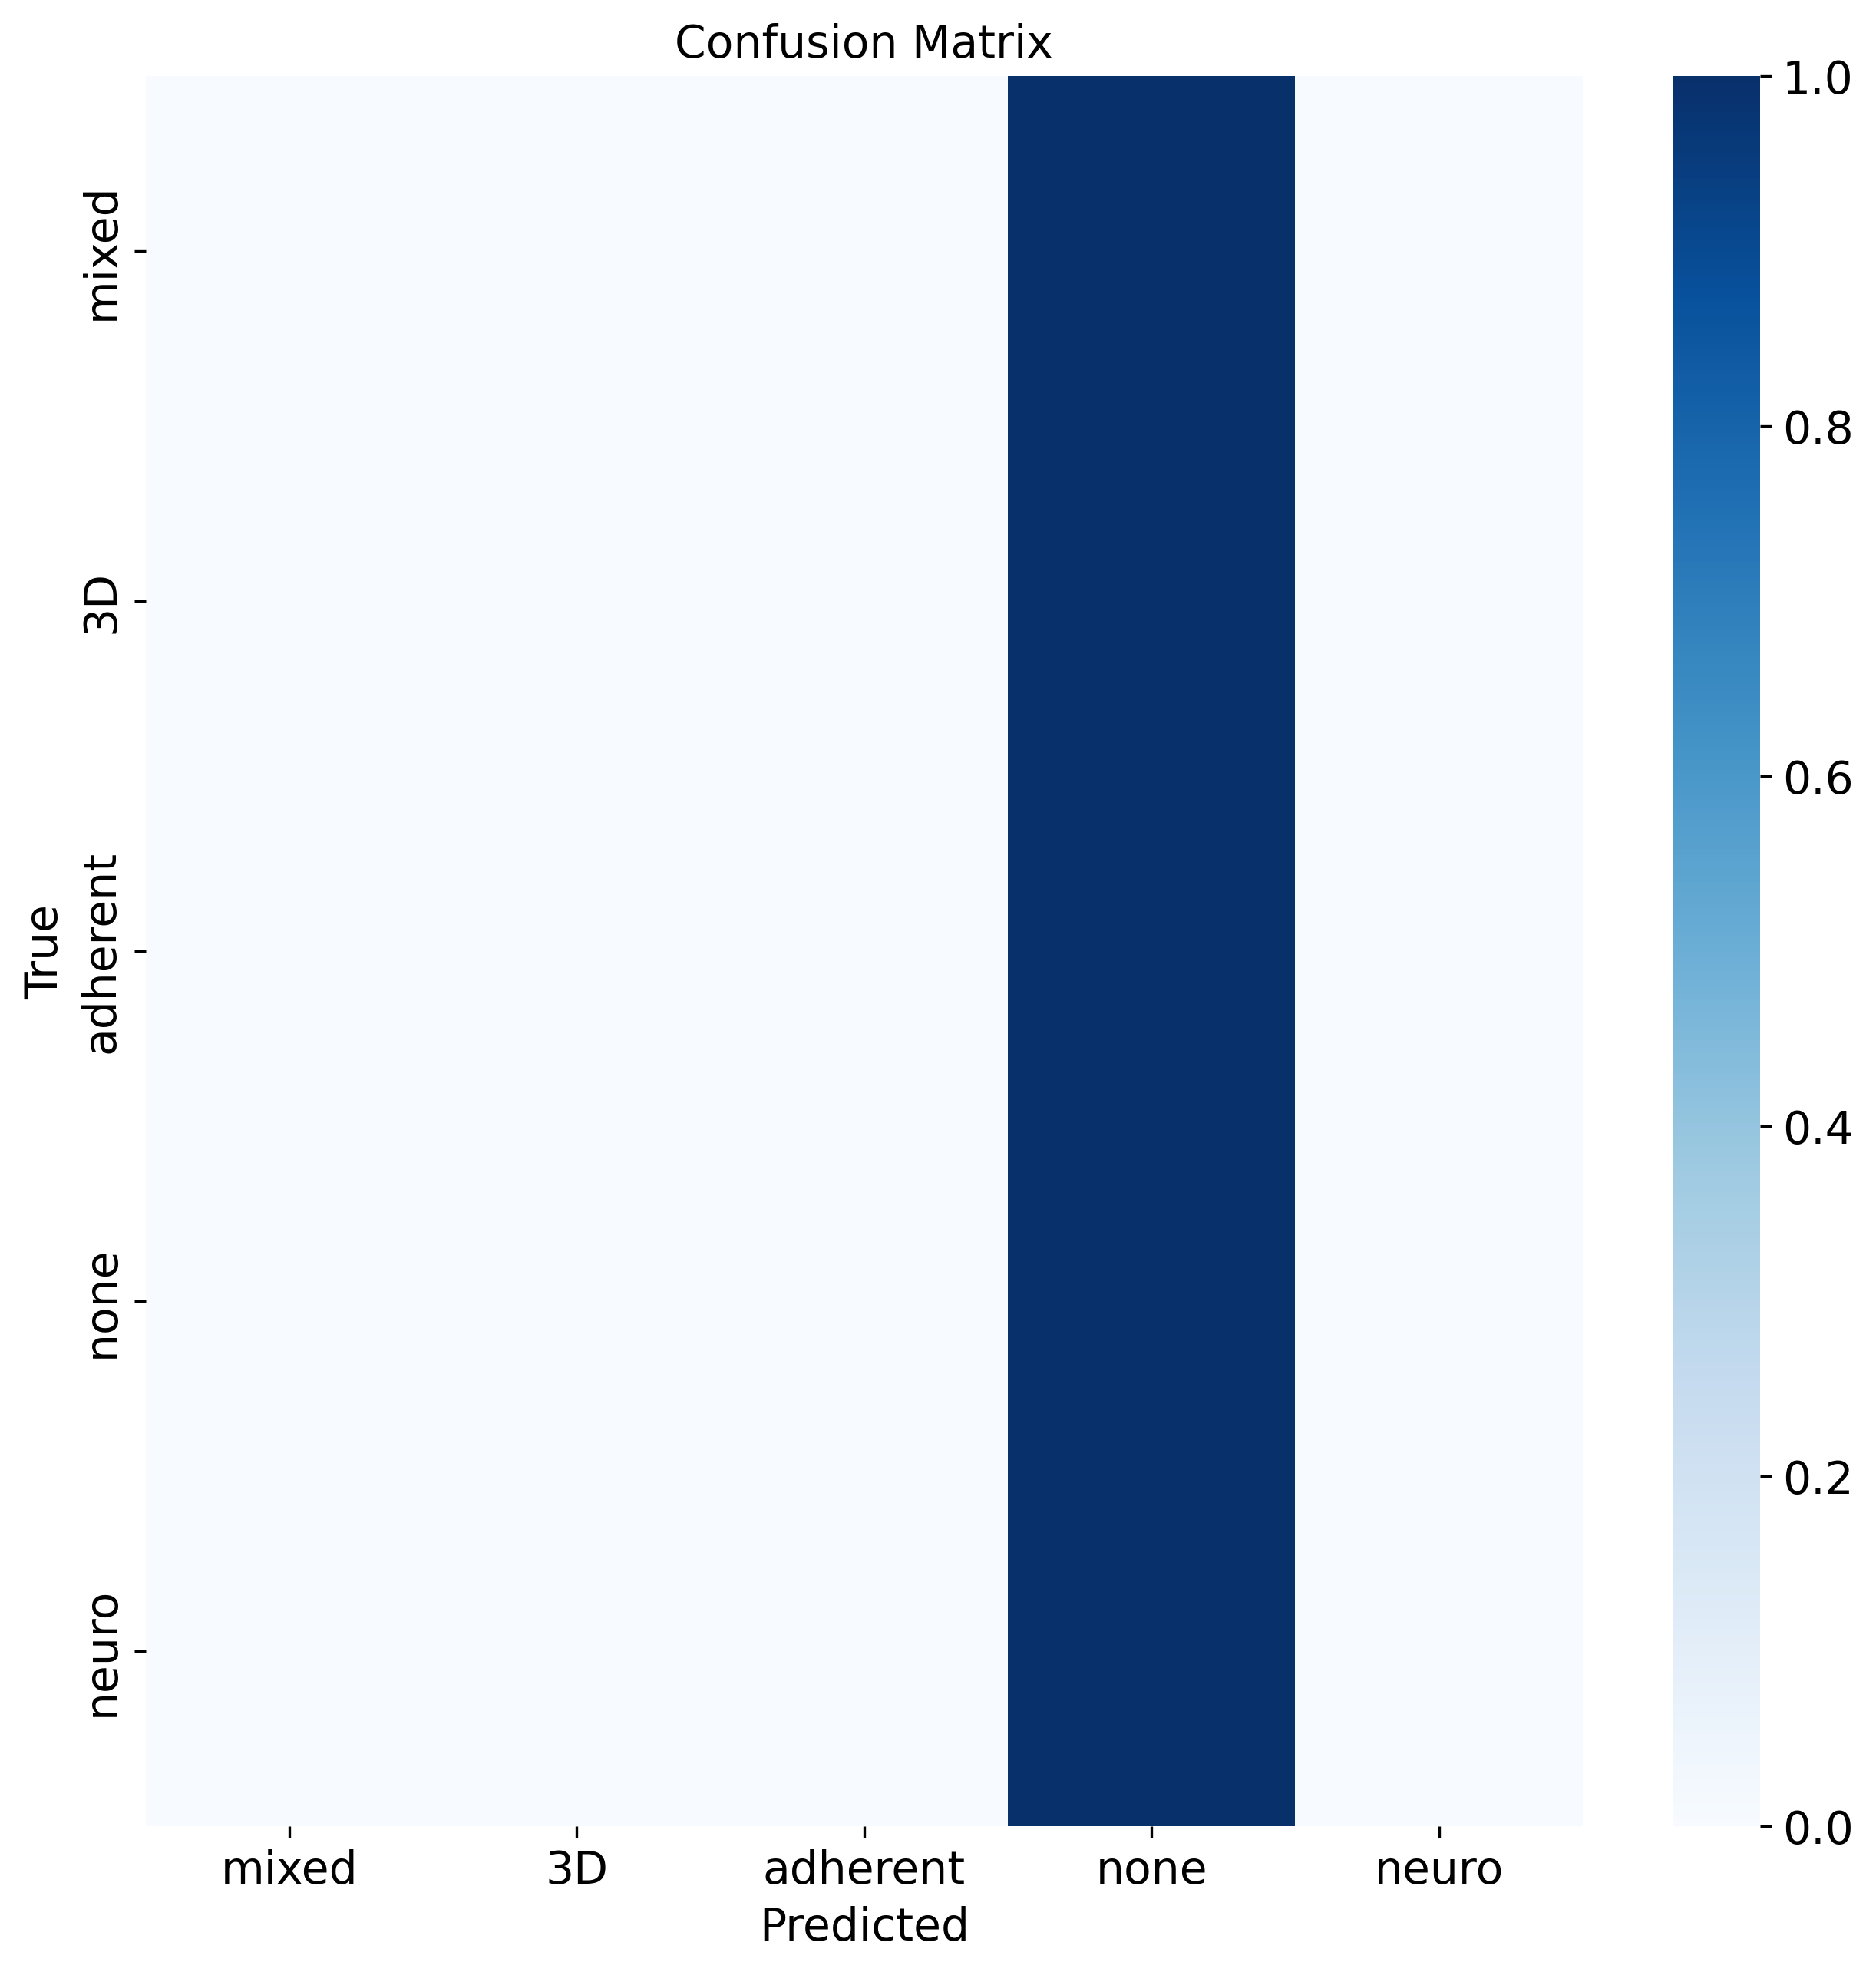

In [31]:
conf = evaluator.get_confusion_matrix(of="morphology", only=None,)

In [32]:
conf = evaluator.getconfusionMatrix(of="contamination")

AttributeError: 'CELLIGNER2_EVAL' object has no attribute 'getconfusionMatrix'

In [ ]:
conf = evaluator.getconfusionMatrix(of="lineage", only=None, font_scale=.7)

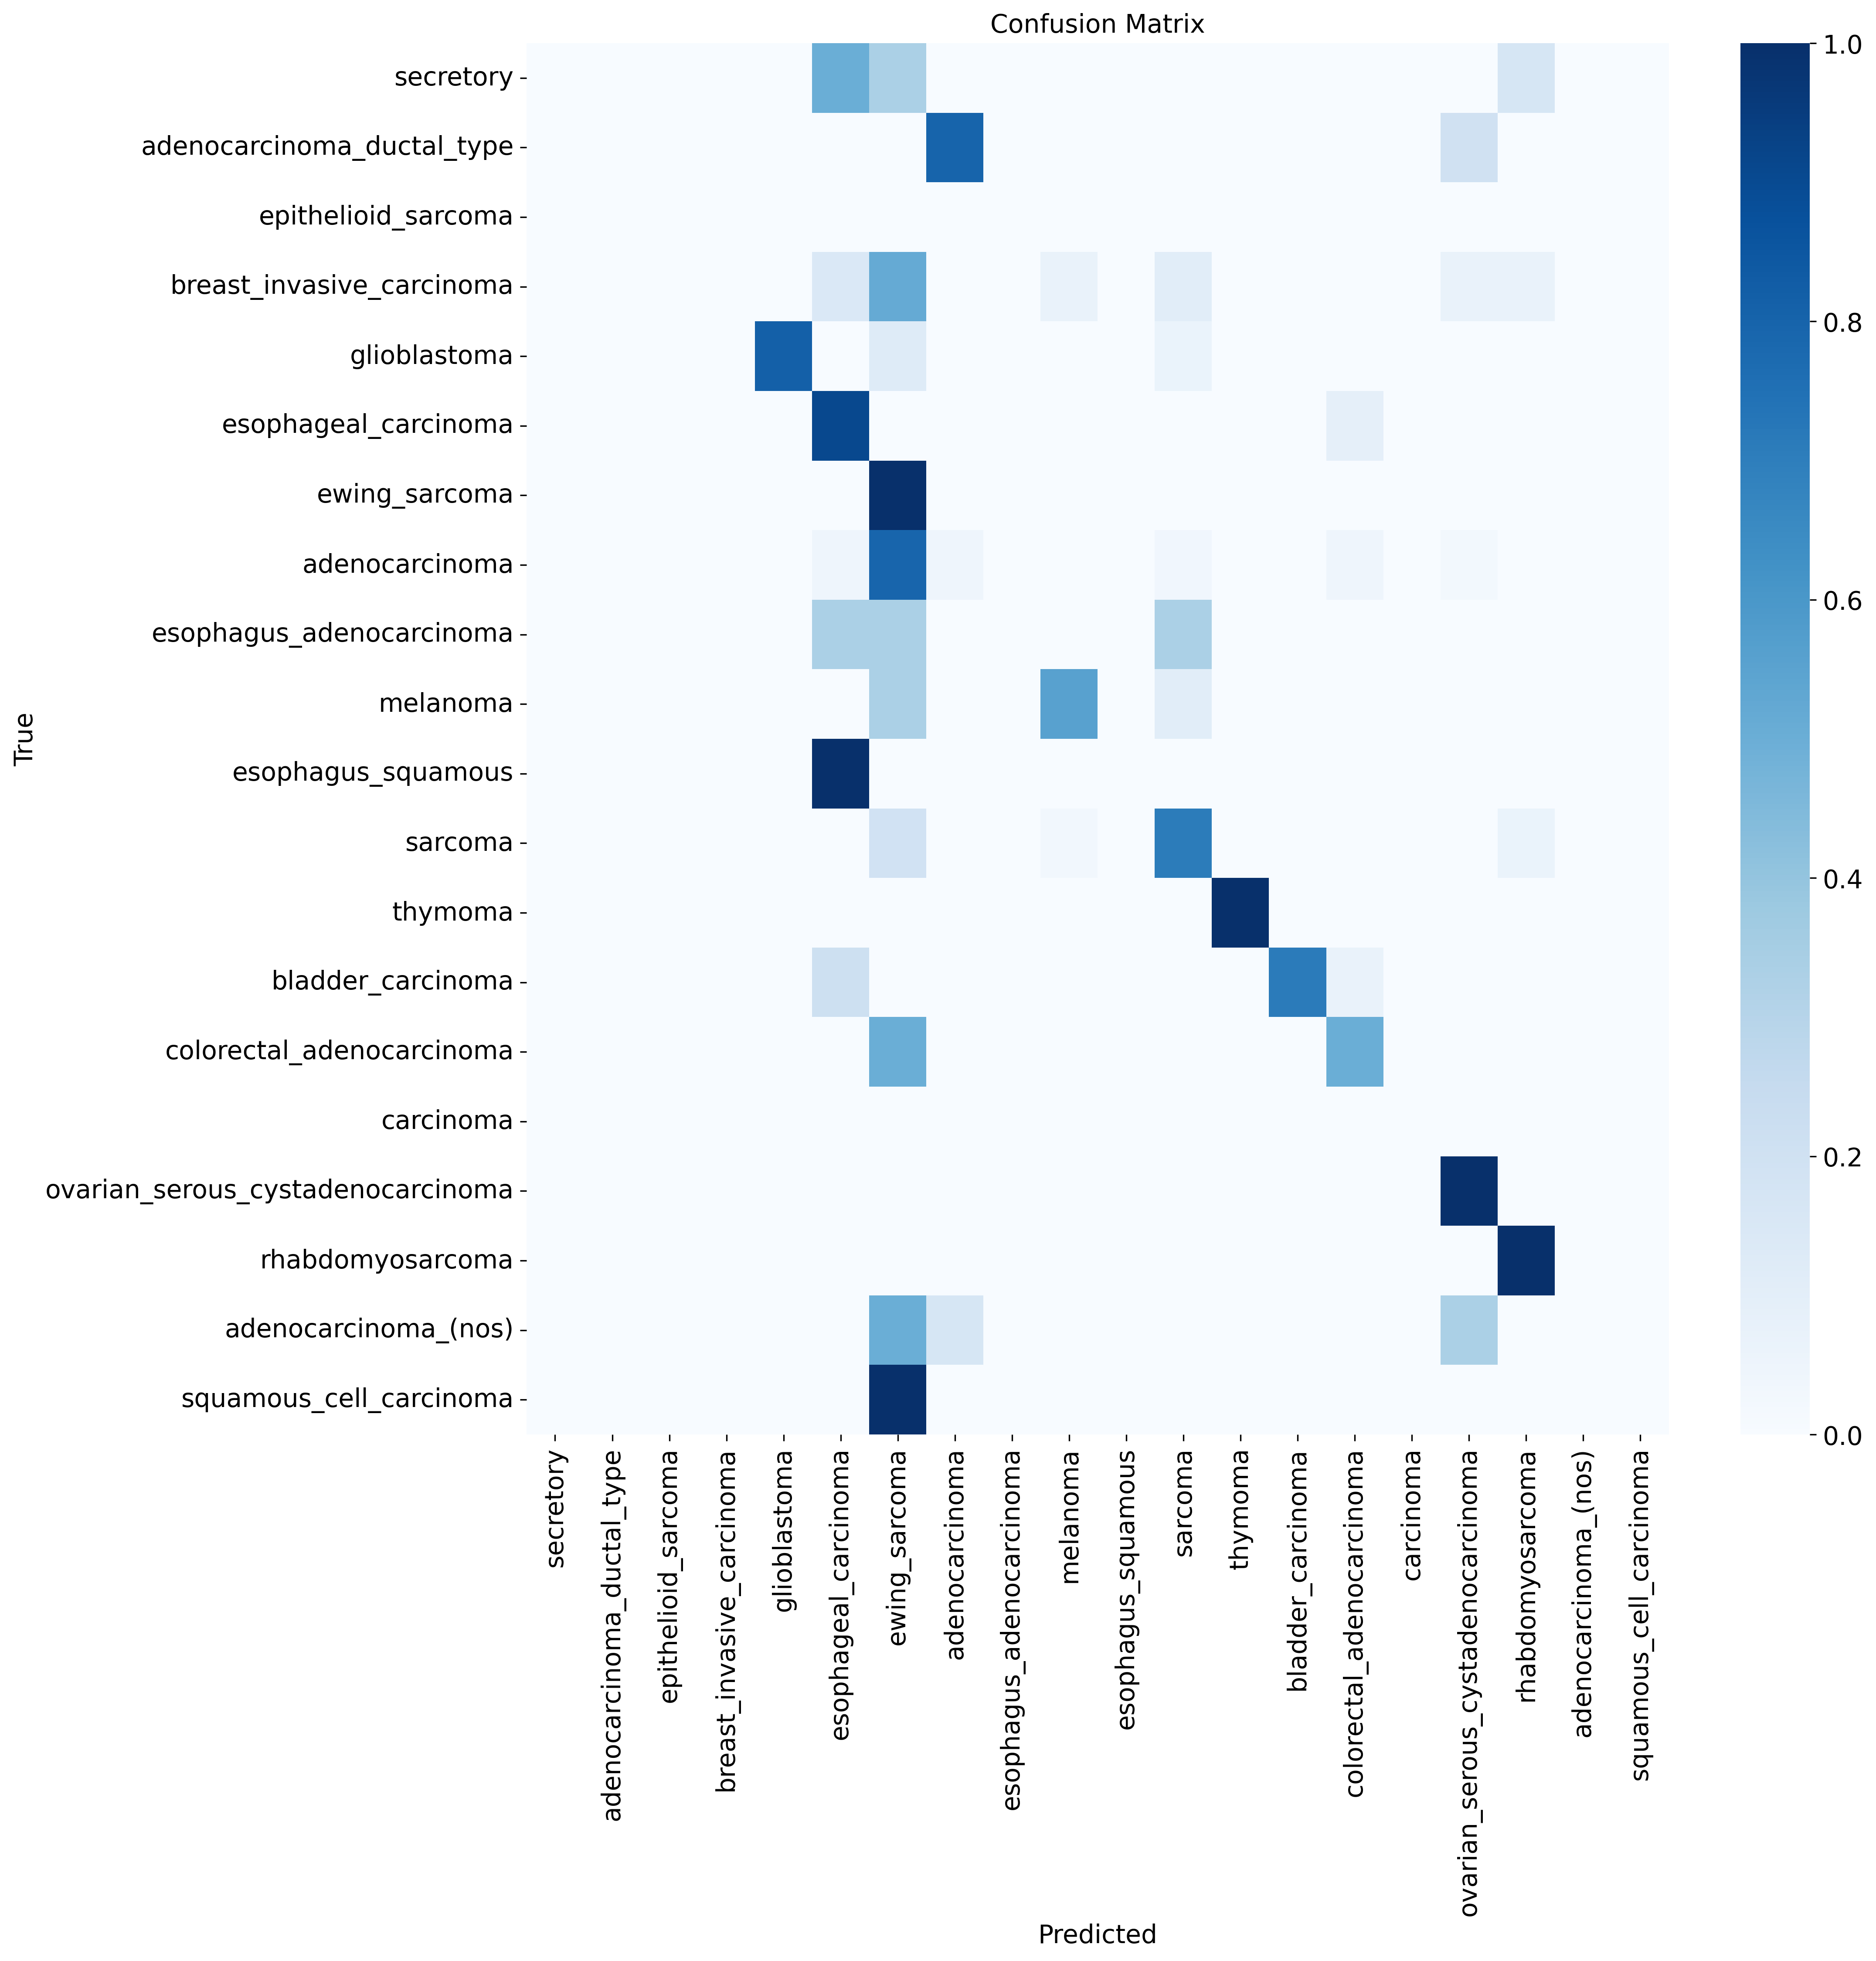

In [33]:
conf = evaluator.get_confusion_matrix(of="disease_type", only=['hcmi','met500'], on="dataset", figsize=(14,14), font_scale=.3)

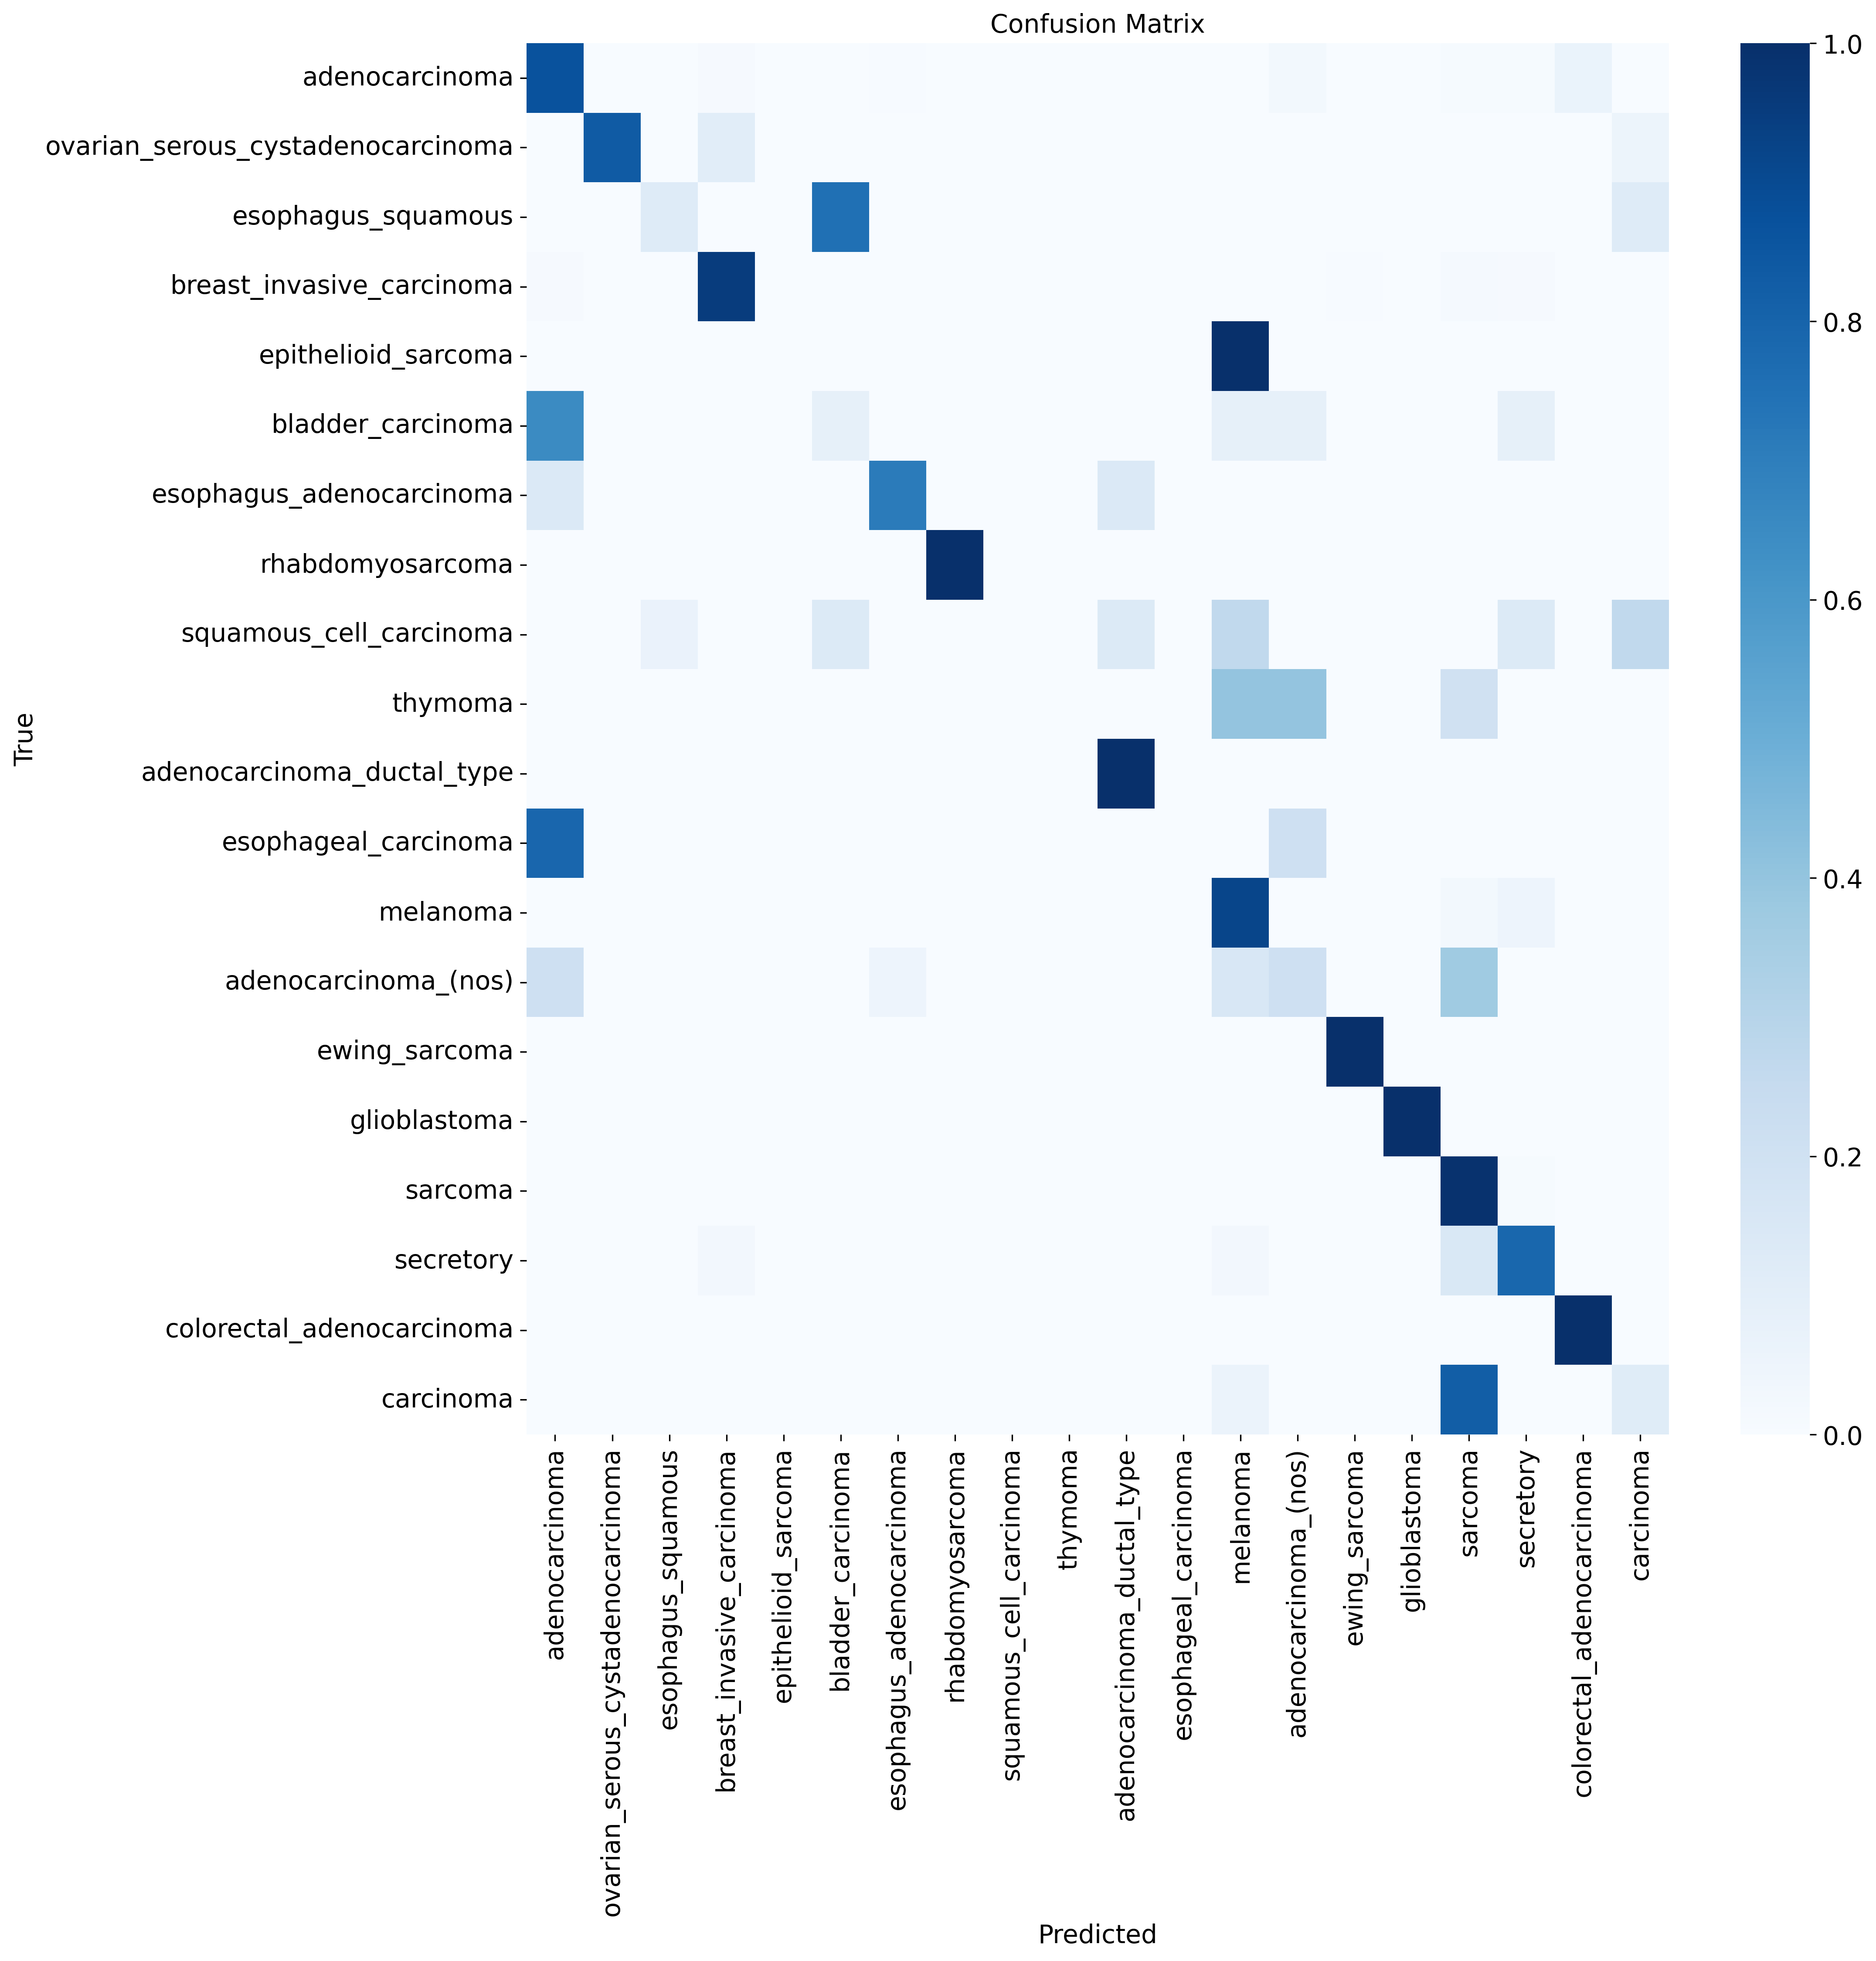

In [120]:
conf = evaluator.get_confusion_matrix(of="disease_type", only=['hcmi','met500'], on="dataset", figsize=(14,14), font_scale=.3)

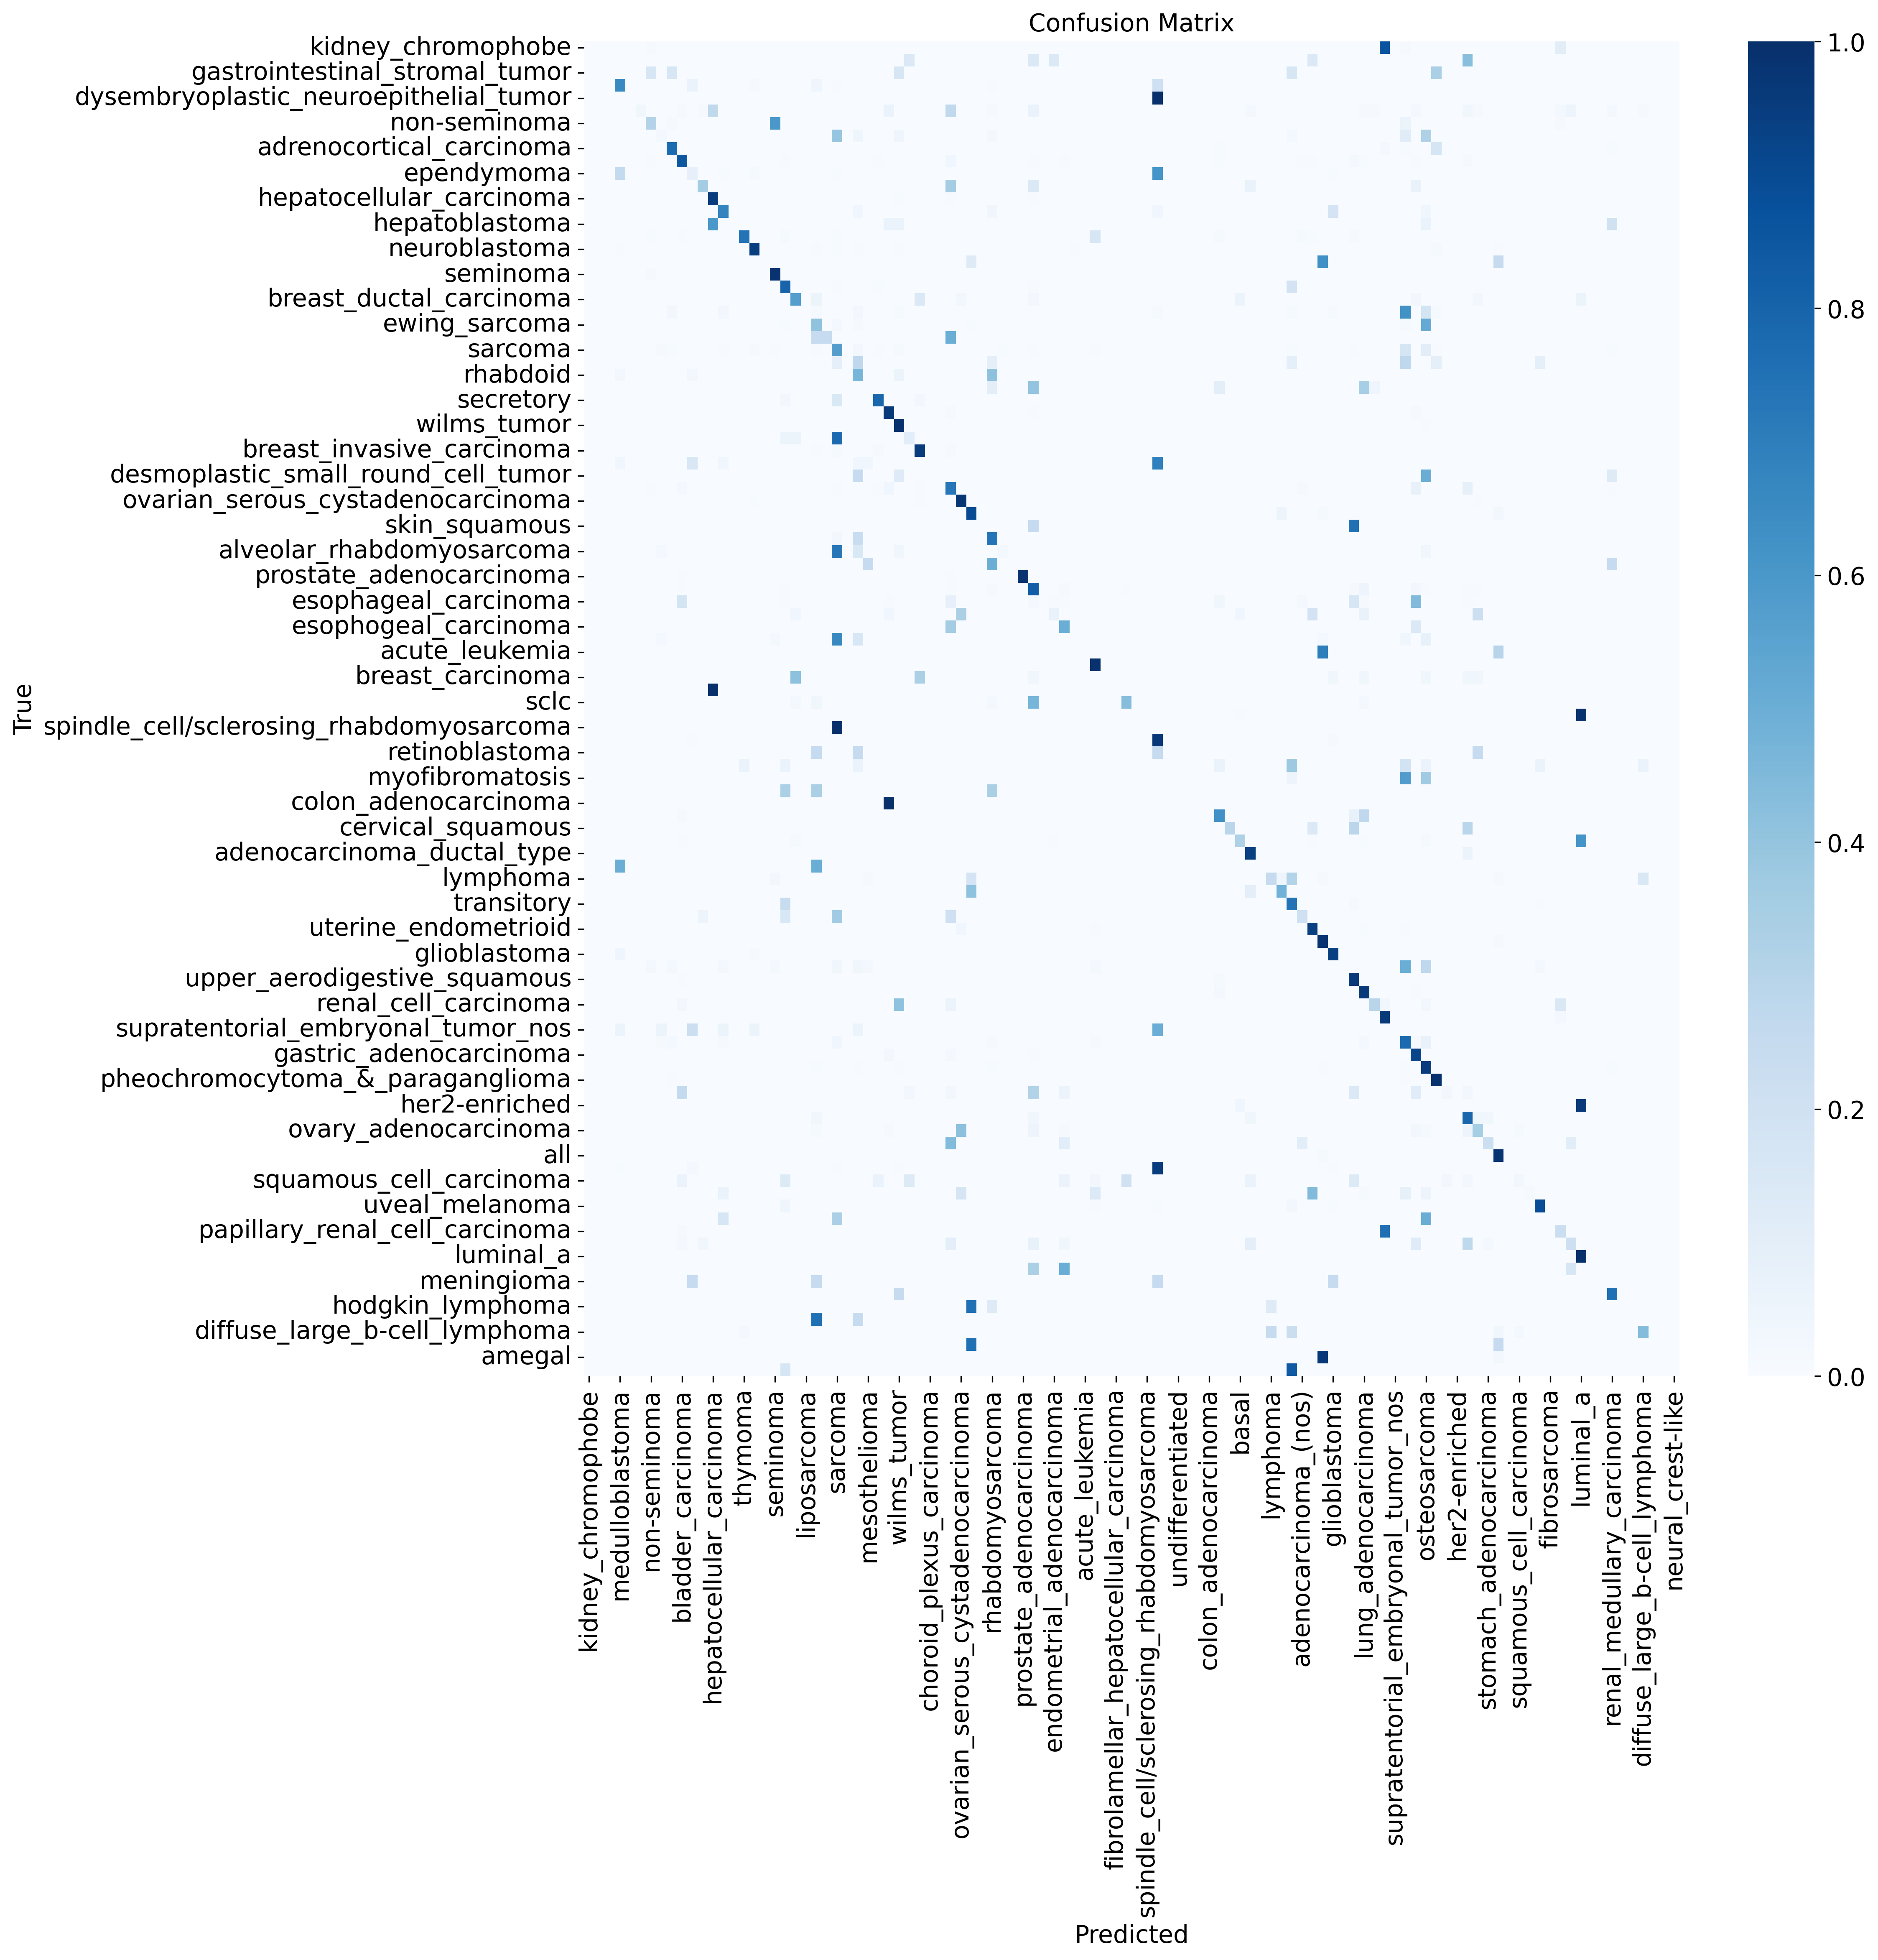

In [119]:
conf = evaluator.get_confusion_matrix(of="disease_type", figsize=(14,14), font_scale=.3)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'lineage_pred' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age_pred' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed

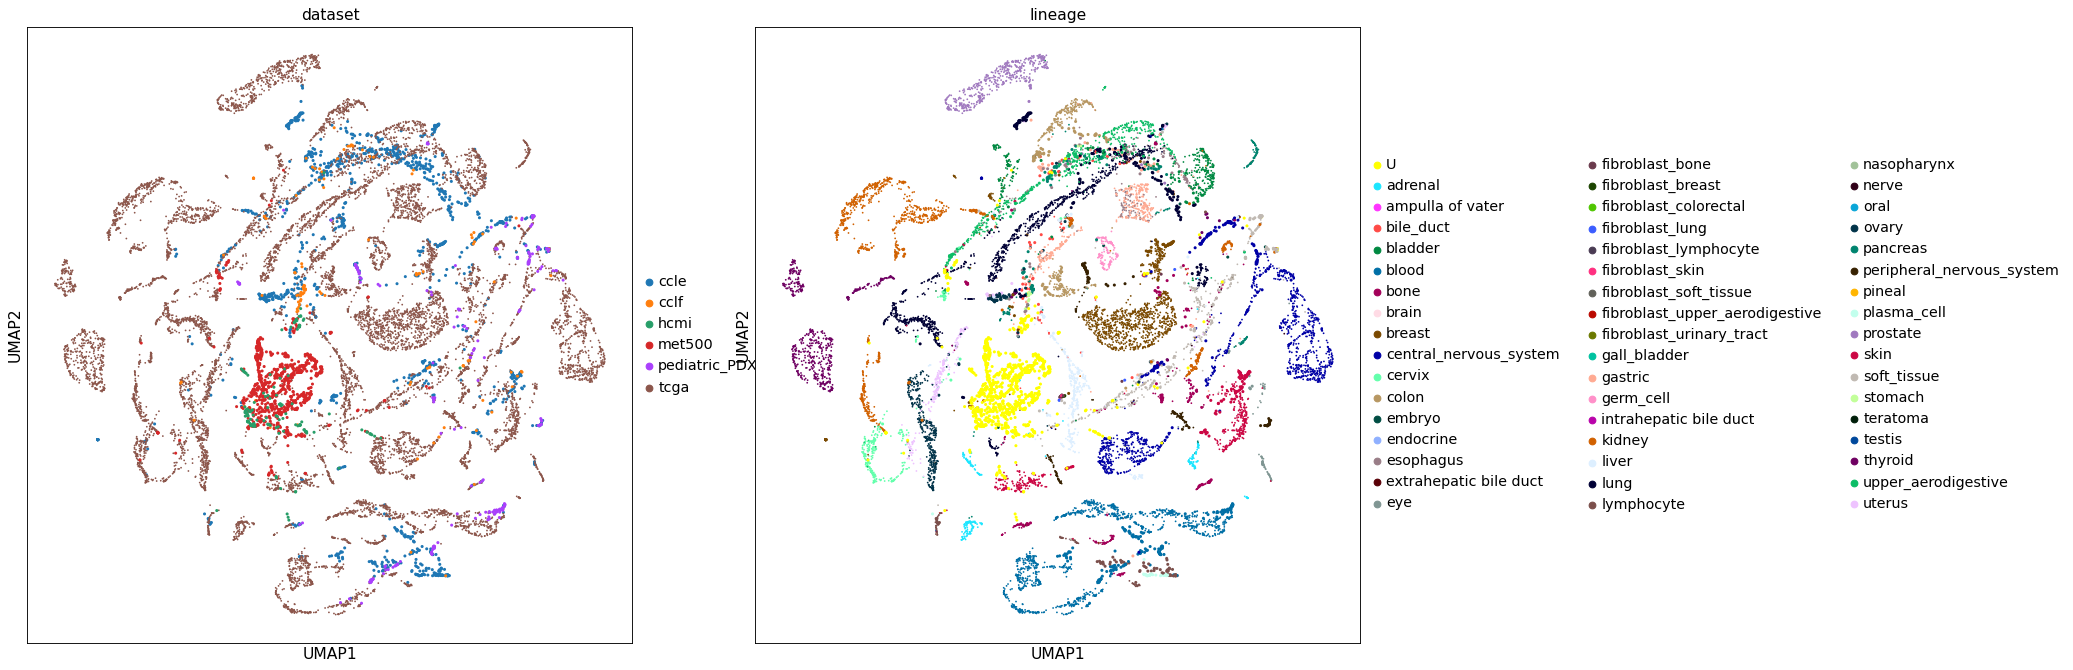

In [37]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.3,
                            alpha=1,
                            spread=3,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    #add_outline = True,
                    size = [30 if val != 'tcga' else 10 for val in dataset.obs['dataset']])